In [68]:
import pickle

In [136]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import random
import seaborn as sns

# Reading the training, validation and test pickled files.

In [419]:
training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

In [420]:
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [421]:
# Mapping ClassID to traffic sign names
signs = []
with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

In [422]:
signs[:5]  #These are the first 5 out of 43 labels for the dataset. 

['Speed limit (20km/h)',
 'Speed limit (30km/h)',
 'Speed limit (50km/h)',
 'Speed limit (60km/h)',
 'Speed limit (70km/h)']

The pickled data is a dictionary with 4 key/value pairs:

'features' is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
'labels' is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.
'sizes' is a list containing tuples, (width, height) representing the original width and height the image.
'coords' is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

In [423]:
len(train['features']) #number of images in the training set. 

34799

In [424]:
len(valid['features']) #number of images in the validation set. 

4410

In [425]:
len(test['features']) #number of images in the test set. 

12630

In [737]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Image data shape = (32, 32, 3)
Number of classes = 43


In [427]:
#This is the original form of the data, but as Keras is able to create dynamic validation sets, 
#I will join the training and validation set under X_train.

In [547]:
X_train.shape

(34799, 32, 32, 3)

# Combining the train and validation sets. 

In [429]:
X_train = np.concatenate((X_train,X_valid), axis=0)
y_train = np.concatenate((y_train,y_valid), axis=0)

In [430]:
X_train.shape

(39209, 32, 32, 3)

In [431]:
y_train.shape

(39209,)

In [432]:
del X_valid, y_valid

In [84]:
#Creating a function to display some of the images. 

In [85]:
def show_images(data, data_label, ylabel="", cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            label (Default = No label): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(20, 16))
    for i in range(4):
        plt.subplot(1, 6 , i+1)
        indx = random.randint(0, len(data))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(data[indx].shape) == 2 else cmap
        plt.imshow(data[indx], cmap = cmap)
        plt.xlabel(signs[data_label[indx]], fontsize=16)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=5, h_pad=5, w_pad=4)
    plt.savefig(f'{ylabel}_images.png', transparent=True, format= 'png')
    plt.show()

# Displaying some of the images from the sets. 

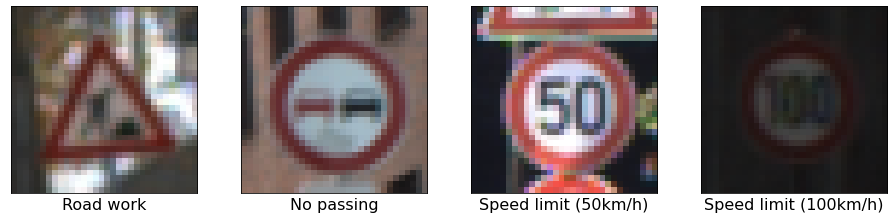

In [434]:
show_images(X_train, y_train, "Training example")

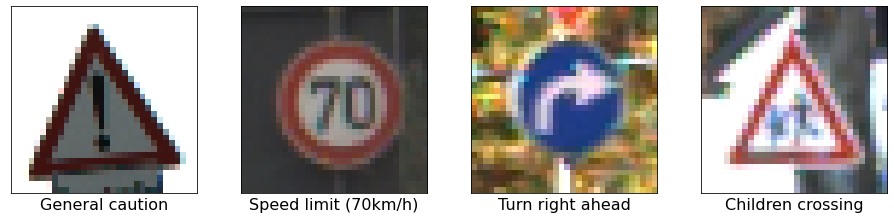

In [435]:
show_images(X_test, y_test, "Testing example")

# Now, seeing the distribution of classes in the training data set. 

In [88]:
def class_dist(data_labels, label):
    unique, counts = np.unique(data_labels, return_counts=True)
    plt.figure(figsize=(10, 6))
    plt.bar(unique, counts, 0.5, color='#0066ff')
    plt.title('Class Frequency')
    plt.xlabel(label)
    plt.ylabel('Count')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(np.arange(min(data_labels), max(data_labels)+1, 3))
    #plt.savefig(f'{label}classes.png', transparent=True, format= 'png')
    plt.show()

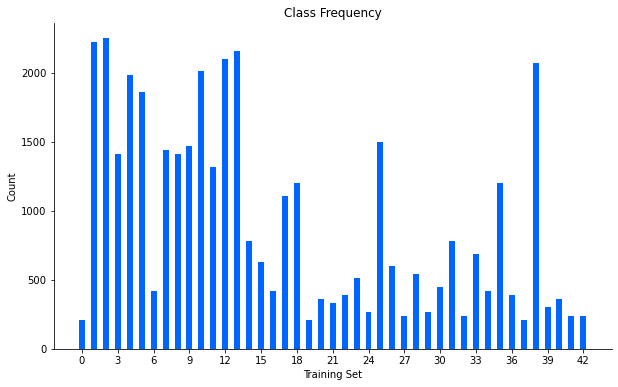

In [344]:
class_dist(y_train, 'Training Set')

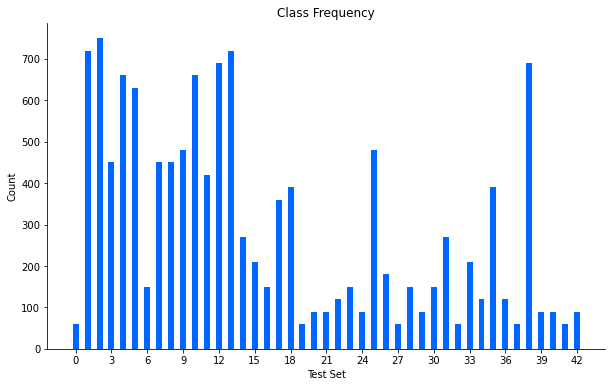

In [345]:
class_dist(y_test, 'Test Set')

In [382]:
unique, counts = np.unique(y_train, return_counts=True)
for i in unique:
    print(f"{unique[i]}: {counts[i]}")
#print(counts)

0: 210
1: 2220
2: 2250
3: 1410
4: 1980
5: 1860
6: 420
7: 1440
8: 1410
9: 1470
10: 2010
11: 1320
12: 2100
13: 2160
14: 780
15: 630
16: 420
17: 1110
18: 1200
19: 210
20: 360
21: 330
22: 390
23: 510
24: 270
25: 1500
26: 600
27: 240
28: 540
29: 270
30: 450
31: 780
32: 240
33: 689
34: 420
35: 1200
36: 390
37: 210
38: 2070
39: 300
40: 360
41: 240
42: 240


In [91]:
#11-22-2021. Today, my goal is to fit a tree base model and a baseline CNN. 

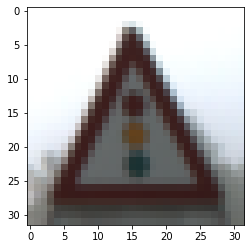

In [661]:
plt.imshow(X_train[1675,:,:,:])

In [653]:
X_train.shape

(34799, 32, 32, 3)

In [474]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils

In [475]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint


In [476]:
#I'm gonna try to fit the model with these images without pre-processing. 

In [738]:
n_classes = 43
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_valid = np_utils.to_categorical(y_valid, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (34799,)
Shape after one-hot encoding:  (34799, 43)


In [742]:
#Building a baseline CNN model.  
model = Sequential()
# convolutional layer
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(32,32,3)))
model.add(Dropout(0.2))
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
# flatten output of conv
model.add(Flatten())
# hidden layer
model.add(Dense(100, activation='relu'))
# output layer
model.add(Dense(43, activation='softmax'))

In [743]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [744]:
history = model.fit(X_train, Y_train,\
                    batch_size=128, \
                    epochs=60,\
                    validation_data=(X_valid, Y_valid), 
                   callbacks = callbacksb)

Epoch 1/60
272/272 [==============================] - 39s 142ms/step - loss: 3.0891 - accuracy: 0.5284 - val_loss: 0.7640 - val_accuracy: 0.7982 - lr: 0.0010
Epoch 2/60
272/272 [==============================] - 40s 147ms/step - loss: 0.3160 - accuracy: 0.9185 - val_loss: 0.4926 - val_accuracy: 0.8692 - lr: 0.0010
Epoch 3/60
272/272 [==============================] - 40s 147ms/step - loss: 0.1591 - accuracy: 0.9590 - val_loss: 0.4890 - val_accuracy: 0.8748 - lr: 0.0010
Epoch 4/60
272/272 [==============================] - 39s 144ms/step - loss: 0.0968 - accuracy: 0.9753 - val_loss: 0.3793 - val_accuracy: 0.9063 - lr: 0.0010
Epoch 5/60
272/272 [==============================] - 39s 144ms/step - loss: 0.0742 - accuracy: 0.9804 - val_loss: 0.3671 - val_accuracy: 0.9138 - lr: 0.0010
Epoch 6/60
272/272 [==============================] - 39s 144ms/step - loss: 0.0653 - accuracy: 0.9817 - val_loss: 0.2976 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 7/60
272/272 [==============================] 

272/272 [==============================] - 37s 138ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.4127 - val_accuracy: 0.9456 - lr: 1.0000e-04
Epoch 52/60
272/272 [==============================] - 38s 138ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.4021 - val_accuracy: 0.9540 - lr: 1.0000e-04
Epoch 53/60
272/272 [==============================] - 37s 138ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.3735 - val_accuracy: 0.9558 - lr: 1.0000e-04
Epoch 54/60
272/272 [==============================] - 37s 138ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.4121 - val_accuracy: 0.9510 - lr: 1.0000e-04
Epoch 55/60
272/272 [==============================] - 37s 138ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.3593 - val_accuracy: 0.9576 - lr: 1.0000e-04
Epoch 56/60
272/272 [==============================] - 38s 139ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.3619 - val_accuracy: 0.9556 - lr: 1.0000e-04
Epoch 57/60
272/272 [=============

In [562]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 dropout_18 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 dropout_19 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_19 (Flatten)        (None, 6272)              0         
                                                     

In [741]:
#Final callback of all of times.
filepath = 'ModeloFinal.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=0, 
                             save_best_only=True,
                             mode='max')

early = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=20, verbose=0, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

csv_logger = CSVLogger('train_logFinal.csv', separator=',')
callbacksb = [checkpoint, reduce_lr, csv_logger]

### Checking the difference in performance of the model between training and test data. 

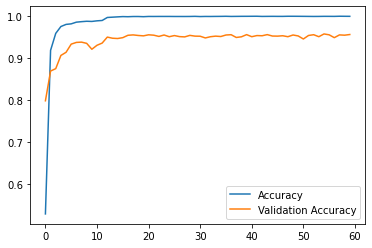

In [745]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy','Validation Accuracy'])

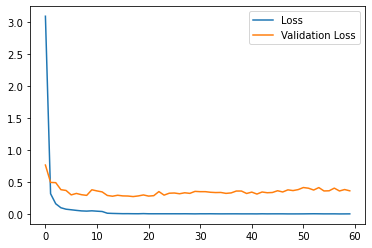

In [746]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss','Validation Loss'])

In [748]:
model = keras.models.load_model(filepath)

In [749]:
pred = np.argmax(model.predict(X_test), axis = 1)

labels = [signs[i] for i in range(43)]

print(classification_report(np.argmax(Y_test, axis=1), pred, target_names = signs))


                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.98      0.83      0.90        60
                              Speed limit (30km/h)       0.93      0.98      0.95       720
                              Speed limit (50km/h)       0.93      0.96      0.94       750
                              Speed limit (60km/h)       0.87      0.96      0.92       450
                              Speed limit (70km/h)       1.00      0.94      0.97       660
                              Speed limit (80km/h)       0.91      0.89      0.90       630
                       End of speed limit (80km/h)       0.99      0.83      0.91       150
                             Speed limit (100km/h)       0.94      0.87      0.90       450
                             Speed limit (120km/h)       0.88      0.96      0.92       450
                                        No passing       0.95      0.96      0.

In [750]:
accuracy_score(y_test, pred)

0.9395091053048298

### Classification report by individual classes

In [132]:
# Confusion matrix

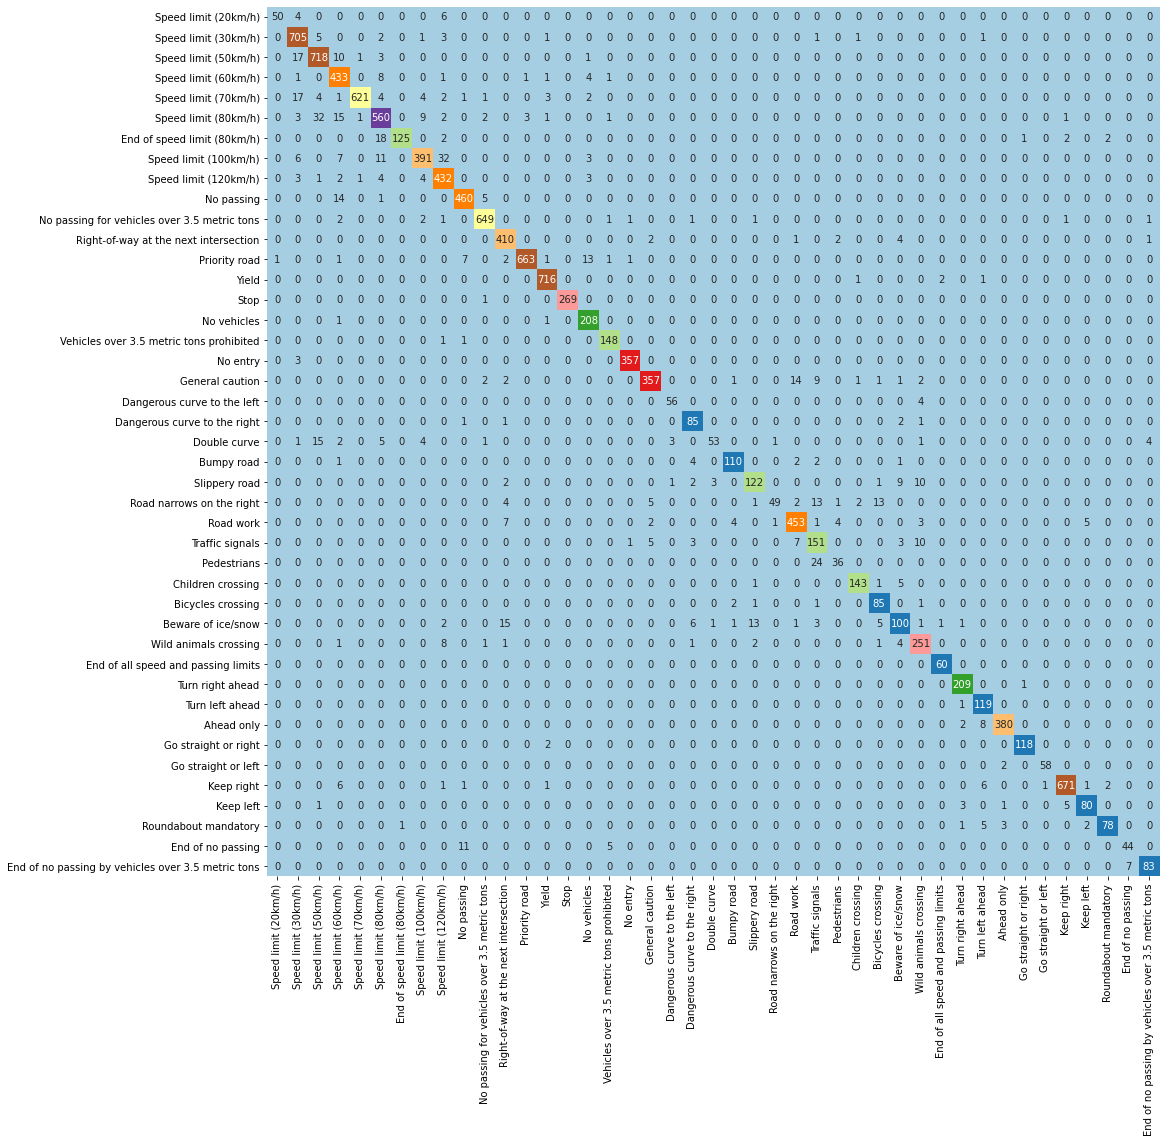

In [852]:
cmat = confusion_matrix(np.argmax(Y_test, axis=1), pred)

plt.figure(figsize=(16,16))

sns.heatmap(cmat, annot = True, cbar = False, cmap='Paired', fmt="d", xticklabels=signs, yticklabels=signs);

# Accuracy by class

In [853]:
classwise_acc = cmat.diagonal()/cmat.sum(axis=1) * 100 

cls_acc = pd.DataFrame({'Class_Label':[signs[i] for i in range(43)], 'Accuracy': classwise_acc.tolist()}, columns = ['Class_Label', 'Accuracy'])

cls_acc.style.format({"Accuracy": "{:,.2f}",}).hide_index().bar(subset=["Accuracy"], color='tomato')

Class_Label,Accuracy
Speed limit (20km/h),83.33
Speed limit (30km/h),97.92
Speed limit (50km/h),95.73
Speed limit (60km/h),96.22
Speed limit (70km/h),94.09
Speed limit (80km/h),88.89
End of speed limit (80km/h),83.33
Speed limit (100km/h),86.89
Speed limit (120km/h),96.00
No passing,95.83


# Let's see some model predictions

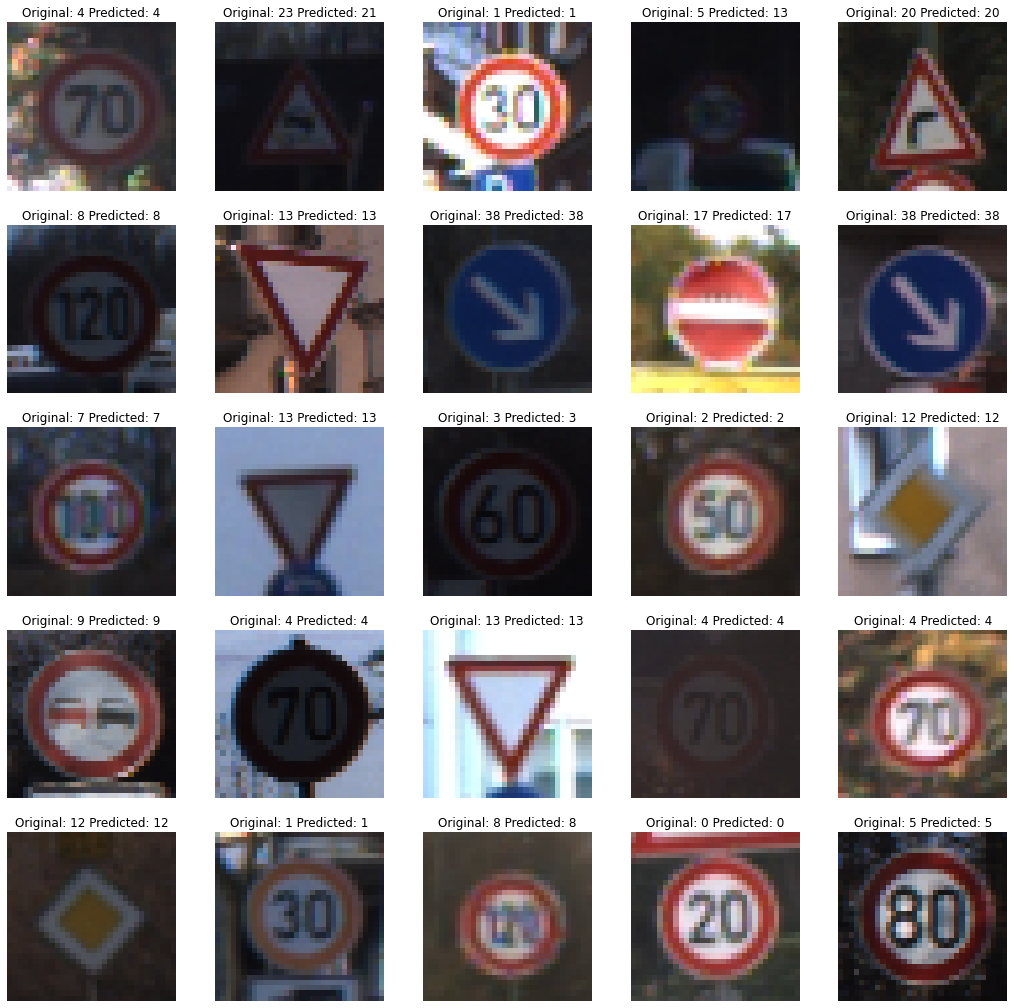

In [145]:
fig, axes = plt.subplots(3,3, figsize=(18,18))
    
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X_test.shape[0])
    ax.imshow(X_test[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Original: {} Predicted: {}'.format(np.argmax(Y_test[r]), np.argmax(model.predict(X_test[r].reshape(1, 32, 32, 3)))))

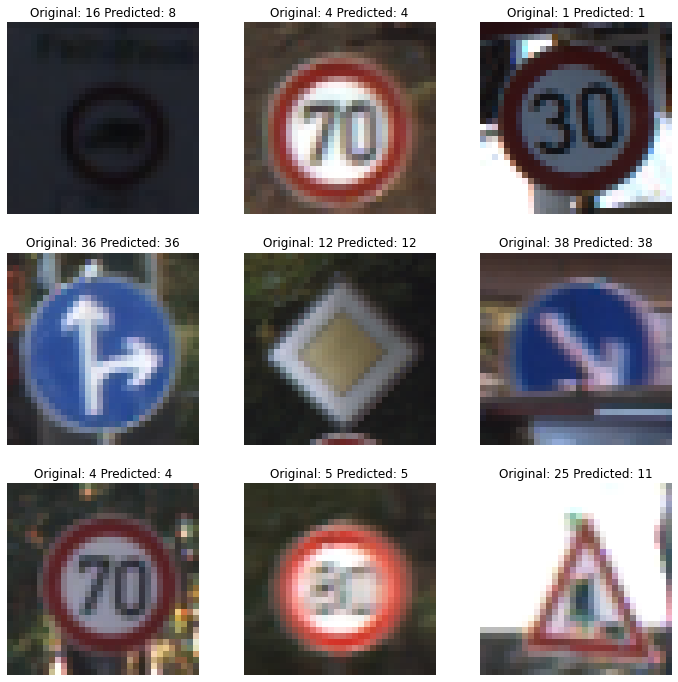

In [772]:
fig, axes = plt.subplots(3,3, figsize=(12,12))
    
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X_test.shape[0])
    ax.imshow(X_test[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Original: {} Predicted: {}'.format(np.argmax(Y_test[r]), np.argmax(model.predict(X_test[r].reshape(1, 32, 32, 3)))))

In [773]:
signs[16]

'Vehicles over 3.5 metric tons prohibited'

In [774]:
signs[8]

'Speed limit (120km/h)'

In [775]:
signs[25]

'Road work'

In [776]:
signs[11]

'Right-of-way at the next intersection'

In [780]:
import os
try:
    path=os.path.join(mypath, n)
    img=cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img=cv2.resize(img, (img_rows, img_cols))

except Exception as e:
    print(str(e))

In [824]:
# Loading and resizing new test images
new_test_images = []
path = '/Users/robertolinares/NBM_DeepLearning_Student/Project/test_images'
for image in os.listdir(path):
    try:
        print(image)
        img = cv2.imread(path + '/' + image)
        img = cv2.resize(img, (32,32))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        new_test_images.append(img)
    except Exception as e:
        print(str(e))
new_IDs = [36, 26, 27, 29, 4]
print("Number of new testing examples: ", len(new_test_images))

00004_00025.ppm
.DS_Store
OpenCV(4.5.4) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

00005_00021.ppm
00000_00015.ppm
00008_00016.ppm
00007_00027.ppm
Number of new testing examples:  5


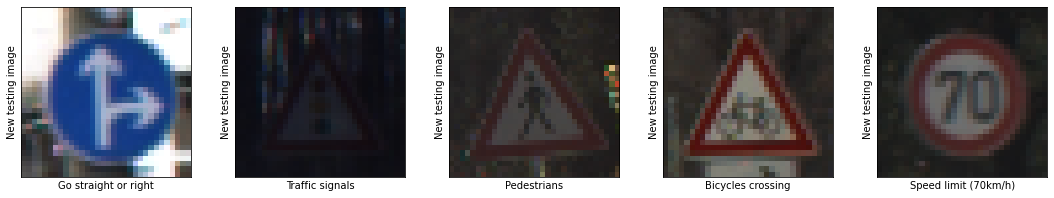

In [825]:
plt.figure(figsize=(15, 16))
for i in range(len(new_test_images)):
    plt.subplot(2, 5, i+1)
    plt.imshow(new_test_images[i])
    plt.xlabel(signs[new_IDs[i]])
    plt.ylabel("New testing image")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=2, h_pad=2, w_pad=3)
plt.show()

In [ ]:
def y_predict_model(Input_data, top_k=5):
    """
    Generates the predictions of the model over the input data, and outputs the top softmax probabilities.
        Parameters:
            X_data: Input data.
            top_k (Default = 5): The number of top softmax probabilities to be generated.
    """
    num_examples = len(Input_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
#     with tf.Session() as sess:
#         VGGNet_Model.saver.restore(sess, os.path.join(DIR, "VGGNet"))
#         y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(VGGNet_Model.logits), k=top_k), 
#                              feed_dict={x:Input_data, keep_prob:1, keep_prob_conv:1})
#     return y_prob, y_pred
    y_pred = model.predict(Input_data)

y_prob, y_pred = y_predict_model(new_test_images)

test_accuracy = 0
for i in enumerate(new_test_images):
    accu = new_IDs[i[0]] == np.asarray(y_pred[i[0]])[0]
    if accu == True:
        test_accuracy += 0.2
print("New Images Test Accuracy = {:.1f}%".format(test_accuracy*100))

plt.figure(figsize=(15, 16))
new_test_images_len=len(new_test_images_preprocessed)
for i in range(new_test_images_len):
    plt.subplot(new_test_images_len, 2, 2*i+1)
    plt.imshow(new_test_images[i]) 
    plt.title(signs[y_pred[i][0]])
    plt.axis('off')
    plt.subplot(new_test_images_len, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), y_prob[i, :])
    labels = [signs[j] for j in y_pred[i]]
    plt.yticks(np.arange(1, 6, 1), labels)
plt.show()

In [845]:
u = np.argmax(model.predict((new_test_images[2].reshape(-1,32,32,3))), axis=-1)

#predP = np.argmax(model.predict(X_test), axis = 1)
u.dtype

dtype('int64')

In [846]:
u

array([27])

In [847]:
signs[int(u)]

'Pedestrians'

In [849]:
signs

['Speed limit (20km/h)',
 'Speed limit (30km/h)',
 'Speed limit (50km/h)',
 'Speed limit (60km/h)',
 'Speed limit (70km/h)',
 'Speed limit (80km/h)',
 'End of speed limit (80km/h)',
 'Speed limit (100km/h)',
 'Speed limit (120km/h)',
 'No passing',
 'No passing for vehicles over 3.5 metric tons',
 'Right-of-way at the next intersection',
 'Priority road',
 'Yield',
 'Stop',
 'No vehicles',
 'Vehicles over 3.5 metric tons prohibited',
 'No entry',
 'General caution',
 'Dangerous curve to the left',
 'Dangerous curve to the right',
 'Double curve',
 'Bumpy road',
 'Slippery road',
 'Road narrows on the right',
 'Road work',
 'Traffic signals',
 'Pedestrians',
 'Children crossing',
 'Bicycles crossing',
 'Beware of ice/snow',
 'Wild animals crossing',
 'End of all speed and passing limits',
 'Turn right ahead',
 'Turn left ahead',
 'Ahead only',
 'Go straight or right',
 'Go straight or left',
 'Keep right',
 'Keep left',
 'Roundabout mandatory',
 'End of no passing',
 'End of no passing 

# This is going to be a checkpoint

In [185]:
#Here, I'll pickle out the X_train, Y_train, X_test and Y_test that I used to generate the first model that is 
#overfitting, I'll also save the 'best model' from this iteration of 20 epochs, based on the validation loss.

In [179]:
pickle_out = open("X_train_checkp","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open("Y_train_checkp","wb")
pickle.dump(Y_train, pickle_out)
pickle_out.close()


pickle_out = open("X_test_checkp","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open("Y_test_checkp","wb")
pickle.dump(Y_test, pickle_out)
pickle_out.close()

In [169]:
filepath = 'my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

# Building the RandomForestClassifier

In [237]:
from sklearn.utils import shuffle

In [436]:
x_rand = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3])
y_rand = y_train
x_rand, y_rand = shuffle(x_rand, y_rand, random_state=42)
#I'm using just the training data and I'll split it for a simple train-test split. 

#But I'll also prepare a holdout set to test the model in the end. 
x_holdout = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3])

In [361]:
y_rand.shape

(39209,)

In [362]:
x_rand.shape

(39209, 3072)

In [363]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [383]:
x_rand_train, x_rand_test, y_rand_train, y_rand_test = train_test_split(x_rand, y_rand, test_size=0.2\
                                                                        ,random_state=40)

In [384]:
clf = RandomForestClassifier(max_features='sqrt', max_depth = 12, n_estimators=200, random_state=42)
print(clf)

RandomForestClassifier(max_depth=12, max_features='sqrt', n_estimators=200,
                       random_state=42)


In [730]:
clf.fit(x_rand_train, y_rand_train)

y_pred=clf.predict(x_rand_test)

In [387]:
y_pred

array([34,  7, 13, ...,  5, 38, 23], dtype=uint8)

In [388]:
y_rand_test

array([34,  7, 13, ..., 38, 38, 23], dtype=uint8)

In [731]:
from sklearn import metrics

#Evaluating the performance of the model on training and test sets. 
print("Accuracy on training:", metrics.accuracy_score(y_rand_train, clf.predict(x_rand_train)))



Accuracy on training: 0.999968119361112


In [443]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy on unseen data:",metrics.accuracy_score(y_test, clf.predict(x_holdout)))

Accuracy on unseen data: 0.71298495645289


In [460]:
w = clf.predict(x_holdout)

array([16,  1, 38, ...,  4,  7, 10], dtype=uint8)

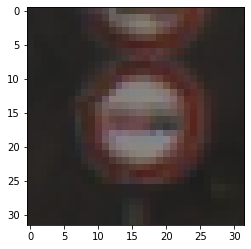

In [441]:
plt.imshow(x_holdout[15,:].reshape(32,32,3))

In [442]:
signs[y_test[15]]

'No passing'

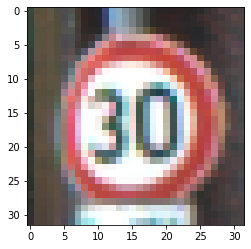

In [403]:
plt.imshow(X_test[1,:].reshape(32,32,3))

# Predictions made by the model

'Speed limit (70km/h)'

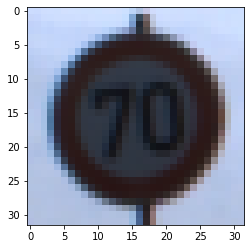

In [459]:
plt.imshow(x_rand_test[20,:].reshape(32,32,3))
signs[y_pred[20]]

'Speed limit (120km/h)'

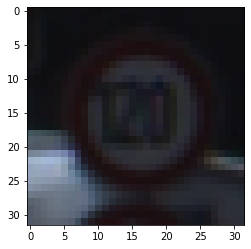

In [458]:
plt.imshow(x_rand_test[25,:].reshape(32,32,3))
signs[y_pred[25]]

'Speed limit (70km/h)'

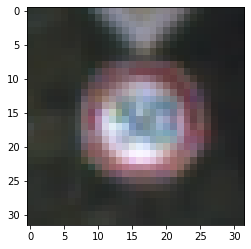

In [457]:
plt.imshow(x_rand_test[30,:].reshape(32,32,3))
signs[y_pred[30]]

'Speed limit (120km/h)'

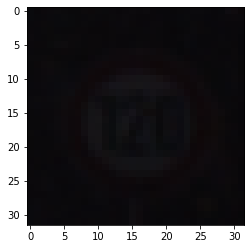

In [456]:
plt.imshow(x_rand_test[55,:].reshape(32,32,3))
signs[y_pred[55]]

'Ahead only'

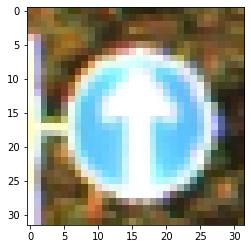

In [461]:
plt.imshow(x_holdout[55,:].reshape(32,32,3))
signs[w[55]]

'Speed limit (30km/h)'

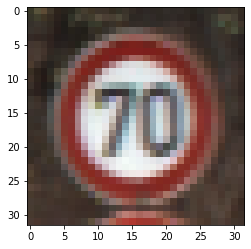

In [462]:
plt.imshow(x_holdout[105,:].reshape(32,32,3))
signs[w[105]]

'No passing'

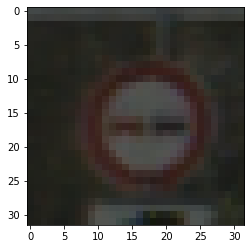

In [463]:
plt.imshow(x_holdout[205,:].reshape(32,32,3))
signs[w[205]]

### Classification report by individual classes. 

In [464]:
labels = [signs[i] for i in range(43)]

print(classification_report(y_rand_test, y_pred, target_names = signs))

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       1.00      0.16      0.27        44
                              Speed limit (30km/h)       0.67      0.87      0.76       456
                              Speed limit (50km/h)       0.54      0.86      0.66       432
                              Speed limit (60km/h)       0.93      0.85      0.89       269
                              Speed limit (70km/h)       0.87      0.83      0.85       384
                              Speed limit (80km/h)       0.74      0.71      0.73       377
                       End of speed limit (80km/h)       0.92      0.95      0.94        84
                             Speed limit (100km/h)       0.88      0.70      0.78       284
                             Speed limit (120km/h)       0.77      0.70      0.73       301
                                        No passing       0.98      0.96      0.

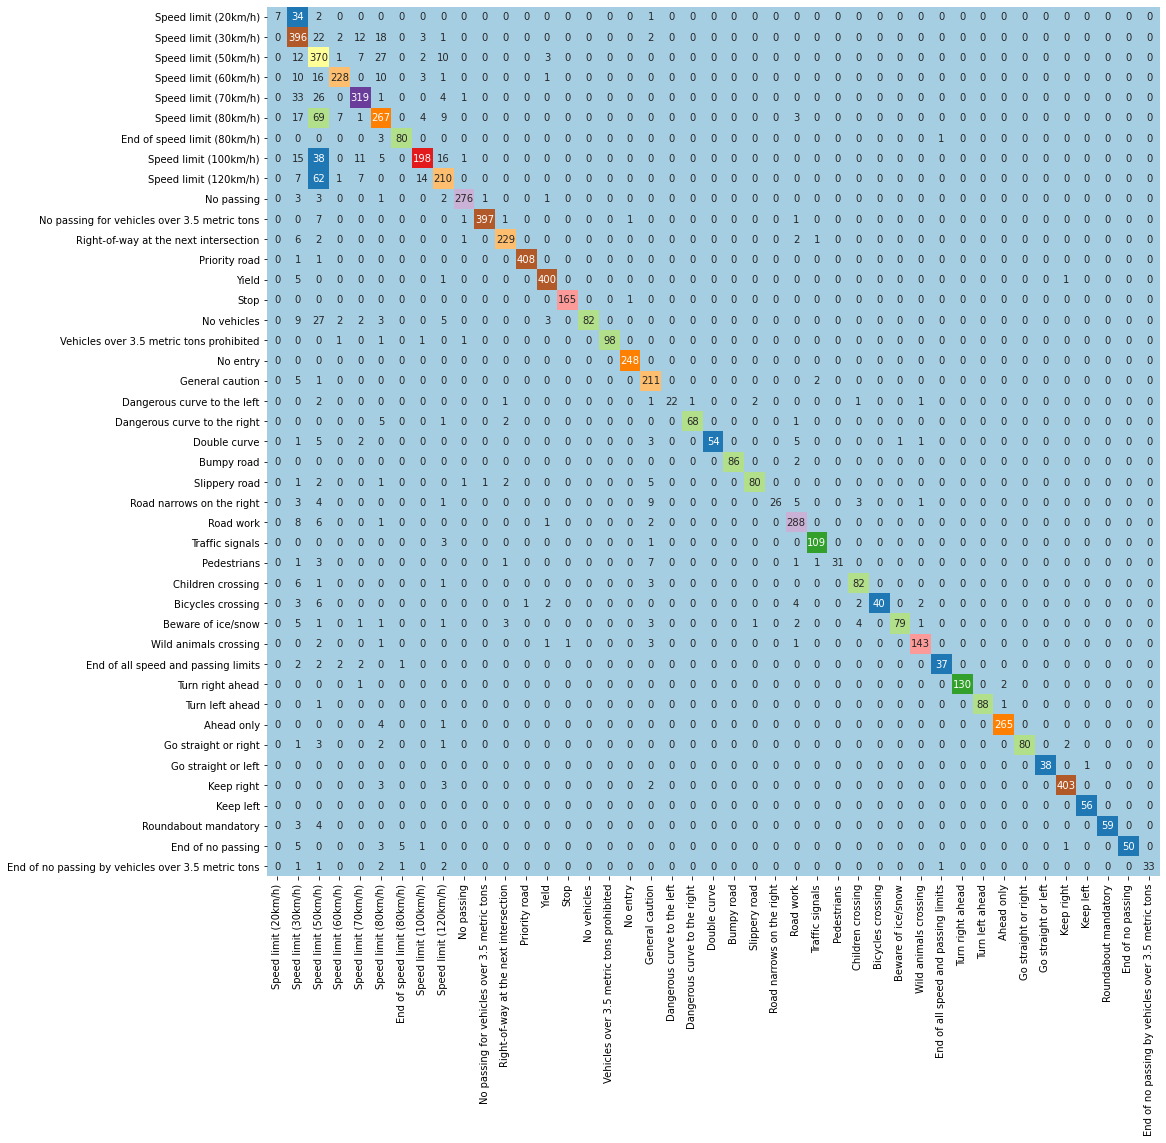

In [465]:
cmat = confusion_matrix(y_rand_test, y_pred)

plt.figure(figsize=(16,16))

sns.heatmap(cmat, annot = True, cbar = False, cmap='Paired', fmt="d", xticklabels=signs, yticklabels=signs);

# Now, trying on the hold out set 

In [322]:
# We can see that the model is overfitting, because it is performing significantly poorly on truly unseen data.

In [333]:
# Let's try to do a RandomSearch with the Random Forests in order to improve the performance on the 
#holdout dataset. 

In [471]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5,20, num=5)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 211, 222, 233, 244, 255, 266, 277, 288, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 8, 12, 16, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True]}


In [472]:
#Base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_rand_train, y_rand_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=211; total time= 2.6min
[CV] END bootstrap=True, max_depth=16, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=288; total time= 7.0min
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 1.7min
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=222; total time= 1.9min
[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=211; total time= 2.6min
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.2min
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total tim

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [5, 8, 12, 16, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 211, 222, 233,
                                                         244, 255, 266, 277,
                                                         288, 300]},
                   random_state=42, verbose=2)

In [473]:
rf_random.best_params_

{'n_estimators': 277,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [485]:
# Trying the Random Forest with the optimized parameters. 

In [487]:
clf2 = RandomForestClassifier(max_features='sqrt', max_depth = 20, n_estimators=277, random_state=42, min_samples_leaf=1,
                            min_samples_split=5)
print(clf2)

RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_split=5,
                       n_estimators=277, random_state=42)


In [488]:
clf2.fit(x_rand_train, y_rand_train)

y_pred2=clf2.predict(x_rand_test)

In [491]:
#Evaluating the performance of the model on training and test sets. 
print("Accuracy on training:", metrics.accuracy_score(y_rand_train, clf2.predict(x_rand_train)))
print("Accuracy on test:", metrics.accuracy_score(y_rand_test, y_pred2))

Accuracy on training: 0.999968119361112
Accuracy on test: 0.9771741902575873


In [493]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy on unseen data:",metrics.accuracy_score(y_test, clf2.predict(x_holdout)))

Accuracy on unseen data: 0.7768012668250198


# Now, I'll be doing preprocessing in the input data to see if I can get better results. 

In [520]:
import cv2
import skimage.morphology as morp
from skimage.filters import rank

### Shuffling the images as a first step

In [670]:
X_train, y_train = shuffle(X_train, y_train)

In [508]:
#Turning images into grayscale. 
def togray(image):
    '''We will provide the images in numpy array format
    will return the image in grayscale'''
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [510]:
#Apply this to the X_train and seeing the images after. 
gray_images = list(map(togray, X_train))

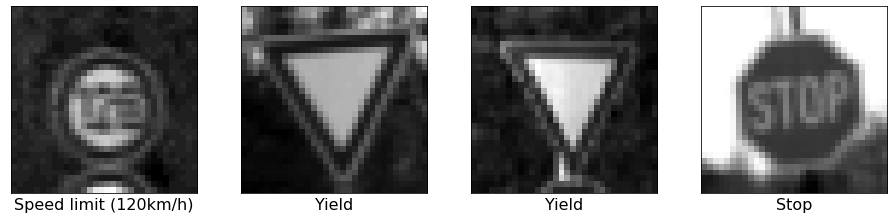

In [513]:
show_images(gray_images, y_train, "Training in gray", "gray")

In [521]:
#Applying histogram equalization to increase the constrast in the images. 
def histo(image):
    """The input for this function will be a gray-scale image
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

In [522]:
#Seeing the images after the equalization. 
equalized_images = list(map(histo, gray_images))

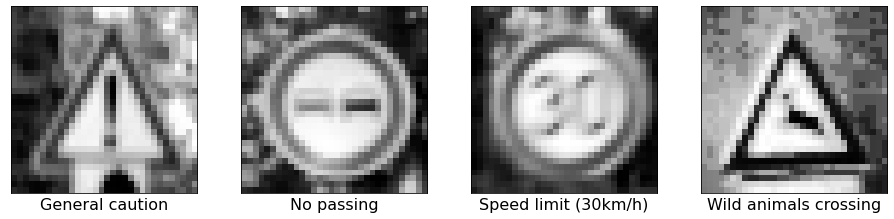

In [523]:
show_images(equalized_images, y_train, "Training equalized", "gray")

In [524]:
#Finally, we will normalize the images. 
def normalize(image):
    """
    Normalize images to [0, 1] scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    image = np.divide(image, 255)
    return image

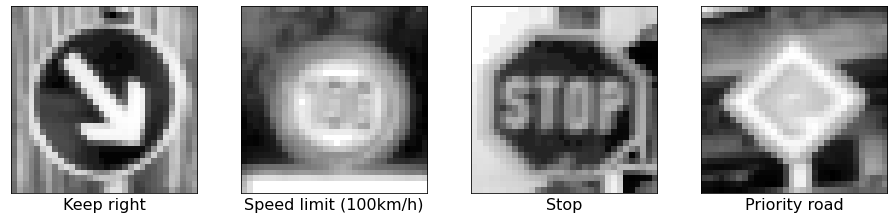

In [526]:
# Sample images after normalization
n_training = X_train.shape
normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
for i, img in enumerate(equalized_images):
    normalized_images[i] = normalize(img)
show_images(normalized_images, y_train, "Normalized Image", "gray")
normalized_images = normalized_images[..., None]

In [527]:
#Now, it's time to build the preprocessing function
def preprocess(data):
    """
    Applying the preprocessing steps to the input data.
        Parameters:
            data: An np.array compatible with plt.imshow.
    """
    gray_images = list(map(togray, data))
    equalized_images = list(map(histo, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = normalize(img)
    normalized_images = normalized_images[..., None]
    return normalized_images

In [671]:
#Now, applying the preprocess to the training and test data. 
X_train_pre = preprocess(X_train)
X_valid_pre = preprocess(X_valid)
X_test_pre = preprocess (X_test)

In [676]:
X_train_pre.shape

(34799, 32, 32, 1)

In [677]:
X_train.shape

(34799, 32, 32, 3)

In [678]:
X_test_pre.shape

(12630, 32, 32, 1)

In [679]:
X_valid_pre.shape

(4410, 32, 32, 1)

In [680]:
n_classes = 43
print("Shape before one-hot encoding: ", y_train.shape)
Y_train_pre = np_utils.to_categorical(y_train, n_classes)
Y_valid_pre = np_utils.to_categorical(y_valid, n_classes)
Y_test_pre = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train_pre.shape)

Shape before one-hot encoding:  (34799,)
Shape after one-hot encoding:  (34799, 43)


In [665]:
#Callbacks to save the best model out of this execution. 

In [666]:
filepath = 'bestPre.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

early = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=6, verbose=0, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

csv_logger = CSVLogger('train_log2.csv', separator=',')
callbacks_pre = [checkpoint, reduce_lr, csv_logger, early]

In [533]:
#Differences for this model will be, applied shuffling, grayscale, equalization and normalization. 

In [681]:
#Building a baseline CNN model.  
model_pre = Sequential()
# convolutional layer
model_pre.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(32,32,1)))
model_pre.add(Dropout(0.2))
model_pre.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
model_pre.add(Dropout(0.2))
model_pre.add(MaxPool2D(pool_size=(2,2), strides=2))
# flatten output of conv
model_pre.add(Flatten())
# hidden layer
model_pre.add(Dense(100, activation='relu'))
# output layer
model_pre.add(Dense(43, activation='softmax'))

model_pre.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')



In [682]:
history_pre = model_pre.fit(X_train_pre, Y_train_pre,\
                            batch_size=128,\
                            epochs=60,\
                            validation_data=(X_valid_pre, Y_valid_pre),\
                           callbacks = callbacks_pre)

Epoch 1/60
272/272 [==============================] - 41s 148ms/step - loss: 1.2151 - accuracy: 0.6815 - val_loss: 0.5379 - val_accuracy: 0.8370 - lr: 0.0010
Epoch 2/60
272/272 [==============================] - 39s 142ms/step - loss: 0.2115 - accuracy: 0.9415 - val_loss: 0.3777 - val_accuracy: 0.8857 - lr: 0.0010
Epoch 3/60
272/272 [==============================] - 42s 154ms/step - loss: 0.1130 - accuracy: 0.9701 - val_loss: 0.3343 - val_accuracy: 0.9045 - lr: 0.0010
Epoch 4/60
272/272 [==============================] - 38s 141ms/step - loss: 0.0699 - accuracy: 0.9816 - val_loss: 0.3272 - val_accuracy: 0.9002 - lr: 0.0010
Epoch 5/60
272/272 [==============================] - 40s 146ms/step - loss: 0.0469 - accuracy: 0.9873 - val_loss: 0.3440 - val_accuracy: 0.8968 - lr: 0.0010
Epoch 6/60
272/272 [==============================] - 41s 149ms/step - loss: 0.0343 - accuracy: 0.9907 - val_loss: 0.2959 - val_accuracy: 0.9190 - lr: 0.0010
Epoch 7/60
272/272 [==============================] 

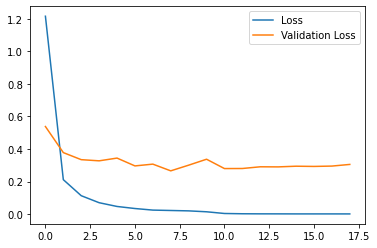

In [683]:
plt.plot(history_pre.history['loss'])
plt.plot(history_pre.history['val_loss'])
plt.legend(['Loss','Validation Loss'])

In [ ]:
model_final_pre = keras.models.load_model('filepath')

In [719]:
# Using the best model to make predictions on the test set. 

In [718]:
pred = np.argmax(model_final_pre.predict(X_test_pre), axis = 1)

labels = [signs[i] for i in range(43)]

print(classification_report(np.argmax(Y_test, axis=1), pred, target_names = signs))

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.82      0.70      0.76        60
                              Speed limit (30km/h)       0.92      0.95      0.94       720
                              Speed limit (50km/h)       0.90      0.99      0.94       750
                              Speed limit (60km/h)       0.91      0.93      0.92       450
                              Speed limit (70km/h)       0.94      0.95      0.94       660
                              Speed limit (80km/h)       0.87      0.87      0.87       630
                       End of speed limit (80km/h)       0.97      0.72      0.83       150
                             Speed limit (100km/h)       0.95      0.90      0.92       450
                             Speed limit (120km/h)       0.90      0.96      0.93       450
                                        No passing       0.94      1.00      0.

'Yield'

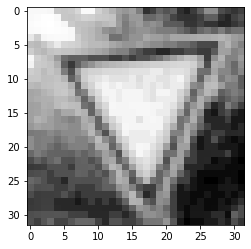

In [540]:
plt.imshow(X_train_pre[1600,:,:,:], 'gray')
signs[y_train[1600]]

In [541]:
# Now trying a new model with different dropout rates.

In [544]:
#Building a baseline CNN model.  
model_64 = Sequential()
# convolutional layer
model_64.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(32,32,1)))
model_64.add(Dropout(0.2))
model_64.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
model_64.add(Dropout(0.2))
model_64.add(MaxPool2D(pool_size=(2,2), strides=2))
# flatten output of conv
model_64.add(Flatten())
# hidden layer
model_64.add(Dense(100, activation='relu'))
# output layer
model_64.add(Dense(43, activation='softmax'))

model_64.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

history64 = model_64.fit(X_train_pre, Y_train_pre, batch_size=128, epochs=20, validation_data=(X_test_pre, Y_test_pre))



Epoch 1/20
307/307 [==============================] - 110s 356ms/step - loss: 1.0639 - accuracy: 0.7264 - val_loss: 0.4582 - val_accuracy: 0.8748
Epoch 2/20
307/307 [==============================] - 107s 350ms/step - loss: 0.1668 - accuracy: 0.9545 - val_loss: 0.3640 - val_accuracy: 0.8998
Epoch 3/20
307/307 [==============================] - 106s 347ms/step - loss: 0.0815 - accuracy: 0.9777 - val_loss: 0.3188 - val_accuracy: 0.9167
Epoch 4/20
307/307 [==============================] - 107s 349ms/step - loss: 0.0494 - accuracy: 0.9858 - val_loss: 0.3229 - val_accuracy: 0.9188
Epoch 5/20
307/307 [==============================] - 111s 361ms/step - loss: 0.0345 - accuracy: 0.9900 - val_loss: 0.3179 - val_accuracy: 0.9185
Epoch 6/20
307/307 [==============================] - 107s 348ms/step - loss: 0.0188 - accuracy: 0.9946 - val_loss: 0.3004 - val_accuracy: 0.9308
Epoch 7/20
307/307 [==============================] - 108s 351ms/step - loss: 0.0204 - accuracy: 0.9939 - val_loss: 0.3519 -

In [545]:
#Model with bigger batch size.
model_b512 = Sequential()
# convolutional layer
model_b512.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(32,32,1)))
model_b512.add(Dropout(0.2))
model_b512.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
model_b512.add(Dropout(0.2))
model_b512.add(MaxPool2D(pool_size=(2,2), strides=2))
# flatten output of conv
model_b512.add(Flatten())
# hidden layer
model_b512.add(Dense(100, activation='relu'))
# output layer
model_b512.add(Dense(43, activation='softmax'))

model_b512.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

historyb512 = model_b512.fit(X_train_pre, Y_train_pre, batch_size=512, epochs=20, validation_data=(X_test_pre, Y_test_pre))




Epoch 1/20
77/77 [==============================] - 47s 597ms/step - loss: 2.3720 - accuracy: 0.3937 - val_loss: 1.2753 - val_accuracy: 0.6705
Epoch 2/20
77/77 [==============================] - 43s 564ms/step - loss: 0.6719 - accuracy: 0.8149 - val_loss: 0.7016 - val_accuracy: 0.8159
Epoch 3/20
77/77 [==============================] - 43s 554ms/step - loss: 0.3341 - accuracy: 0.9098 - val_loss: 0.5511 - val_accuracy: 0.8545
Epoch 4/20
77/77 [==============================] - 46s 597ms/step - loss: 0.2164 - accuracy: 0.9431 - val_loss: 0.4840 - val_accuracy: 0.8732
Epoch 5/20
77/77 [==============================] - 42s 550ms/step - loss: 0.1541 - accuracy: 0.9607 - val_loss: 0.4536 - val_accuracy: 0.8875
Epoch 6/20
77/77 [==============================] - 44s 573ms/step - loss: 0.1182 - accuracy: 0.9706 - val_loss: 0.4107 - val_accuracy: 0.8966
Epoch 7/20
77/77 [==============================] - 44s 568ms/step - loss: 0.0879 - accuracy: 0.9773 - val_loss: 0.3731 - val_accuracy: 0.9098

# Trying Transfer Learning

In [626]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [638]:
filepath = 'best_tl2.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

early = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=6, verbose=0, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

csv_logger = CSVLogger('train_log2.csv', separator=',')
callbacks_tl = [checkpoint, reduce_lr, csv_logger]

In [686]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout
from keras.models import Model
import keras
from keras import optimizers
from tensorflow.keras.applications.resnet50 import preprocess_input
from skimage.transform import resize

In [634]:
#Pre-processing the inputs for the model. 
x_t = preprocess_input(X_train)
x_valid = preprocess_input(X_valid)

In [639]:
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(32,32,3))
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, outputs=output)
for layer in restnet.layers:
    layer.trainable = False
#restnet.summary()

In [640]:
model_tl = Sequential()
model_tl.add(restnet)
model_tl.add(Dense(100, activation='relu'))
model_tl.add(Dropout(0.3))
model_tl.add(Dense(43, activation='softmax'))

In [641]:
model_tl.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [642]:
model_tl.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_10 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_66 (Dense)            (None, 100)               204900    
                                                                 
 dropout_30 (Dropout)        (None, 100)               0         
                                                                 
 dense_67 (Dense)            (None, 43)                4343      
                                                                 
Total params: 23,796,955
Trainable params: 209,243
Non-trainable params: 23,587,712
_________________________________________________________________


In [643]:
history_tl = model_tl.fit(x_t, Y_train,\
                           batch_size=256,\
                          verbose=1,\
                           epochs=50, validation_data=(x_valid, Y_valid),\
                          callbacks=callbacks_tl)

Epoch 1/50
136/136 [==============================] - 59s 416ms/step - loss: 2.4903 - accuracy: 0.3282 - val_loss: 2.2192 - val_accuracy: 0.3746 - lr: 0.0010
Epoch 2/50
136/136 [==============================] - 55s 404ms/step - loss: 1.4956 - accuracy: 0.5287 - val_loss: 2.0196 - val_accuracy: 0.4125 - lr: 0.0010
Epoch 3/50
136/136 [==============================] - 55s 408ms/step - loss: 1.1721 - accuracy: 0.6182 - val_loss: 2.0373 - val_accuracy: 0.4270 - lr: 0.0010
Epoch 4/50
136/136 [==============================] - 56s 412ms/step - loss: 0.9931 - accuracy: 0.6726 - val_loss: 2.0127 - val_accuracy: 0.4478 - lr: 0.0010
Epoch 5/50
136/136 [==============================] - 59s 433ms/step - loss: 0.8648 - accuracy: 0.7143 - val_loss: 2.1237 - val_accuracy: 0.4356 - lr: 0.0010
Epoch 6/50
136/136 [==============================] - 57s 417ms/step - loss: 0.7754 - accuracy: 0.7423 - val_loss: 2.1093 - val_accuracy: 0.4472 - lr: 0.0010
Epoch 7/50
136/136 [==============================] 

# Another shot for transfer learning 

In [697]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import ZeroPadding2D, Dropout 

base = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))

# Freeze convolutional layers
for layer in base.layers:
    layer.trainable = False  


58900480/58889256 [==============================] - 33s 1us/step


In [714]:
VGG16_transfer = Sequential(
                        [base,
                        Flatten(),
                         Dense(1000, activation='relu'),
                         Dropout(0.2),
                         Dense(500, activation='relu'),
                         Dense(43, activation='softmax')]
                       )

VGG16_transfer.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [715]:
VGG16_transfer.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_44 (Flatten)        (None, 512)               0         
                                                                 
 dense_87 (Dense)            (None, 1000)              513000    
                                                                 
 dropout_37 (Dropout)        (None, 1000)              0         
                                                                 
 dense_88 (Dense)            (None, 500)               500500    
                                                                 
 dense_89 (Dense)            (None, 43)                21543     
                                                                 
Total params: 15,749,731
Trainable params: 1,035,043


In [716]:
VGG16_transfer.fit(X_train, Y_train, batch_size=256, epochs=60, verbose=1,\
                   validation_data=(X_valid, Y_valid),\
                  callbacks= callbacks_VGG16)

Epoch 1/60
136/136 [==============================] - 113s 827ms/step - loss: 2.3700 - accuracy: 0.5190 - val_loss: 2.1371 - val_accuracy: 0.4791 - lr: 0.0010
Epoch 2/60
136/136 [==============================] - 111s 818ms/step - loss: 0.7823 - accuracy: 0.7603 - val_loss: 2.2700 - val_accuracy: 0.5147 - lr: 0.0010
Epoch 3/60
136/136 [==============================] - 105s 775ms/step - loss: 0.5170 - accuracy: 0.8389 - val_loss: 2.2882 - val_accuracy: 0.5286 - lr: 0.0010
Epoch 4/60
136/136 [==============================] - 101s 744ms/step - loss: 0.3713 - accuracy: 0.8815 - val_loss: 2.5320 - val_accuracy: 0.5238 - lr: 0.0010
Epoch 5/60
136/136 [==============================] - 99s 725ms/step - loss: 0.2901 - accuracy: 0.9051 - val_loss: 2.7424 - val_accuracy: 0.5091 - lr: 0.0010
Epoch 6/60
136/136 [==============================] - 99s 726ms/step - loss: 0.2408 - accuracy: 0.9233 - val_loss: 3.1037 - val_accuracy: 0.5111 - lr: 0.0010
Epoch 7/60
136/136 [============================

In [703]:
filepath = 'best_VVG16.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

early = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10, verbose=0, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

csv_logger = CSVLogger('train_log2.csv', separator=',')
callbacks_VGG16 = [checkpoint, reduce_lr, csv_logger, early]

In [732]:
modelb = Sequential()
# convolutional layer
modelb.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(32,32,3)))
modelb.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
modelb.add(MaxPool2D(pool_size=(2,2), strides=2))
# flatten output of conv
modelb.add(Flatten())
# hidden layer
modelb.add(Dense(100, activation='relu'))
# output layer
modelb.add(Dense(43, activation='softmax'))

In [733]:
modelb.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_39 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_45 (Flatten)        (None, 6272)              0         
                                                                 
 dense_90 (Dense)            (None, 100)               627300    
                                                                 
 dense_91 (Dense)            (None, 43)                4343      
                                                     

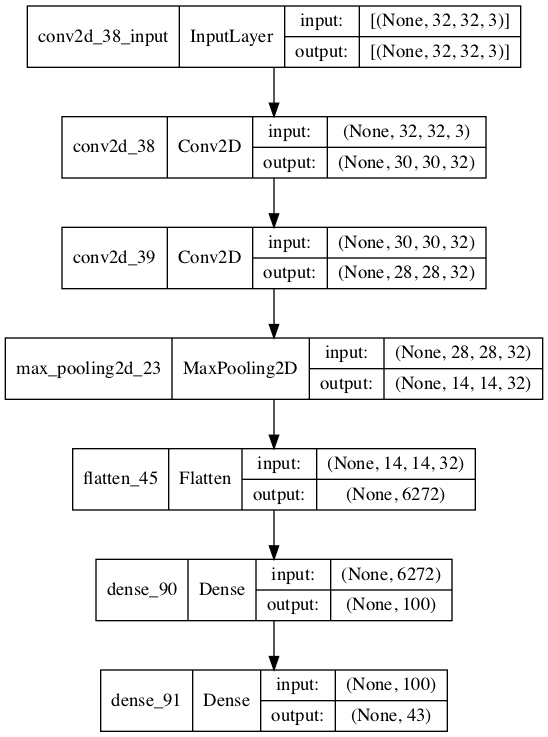

In [736]:
plot_model(modelb, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [735]:
from keras.utils.vis_utils import plot_model


In [777]:
#Final model plot. 

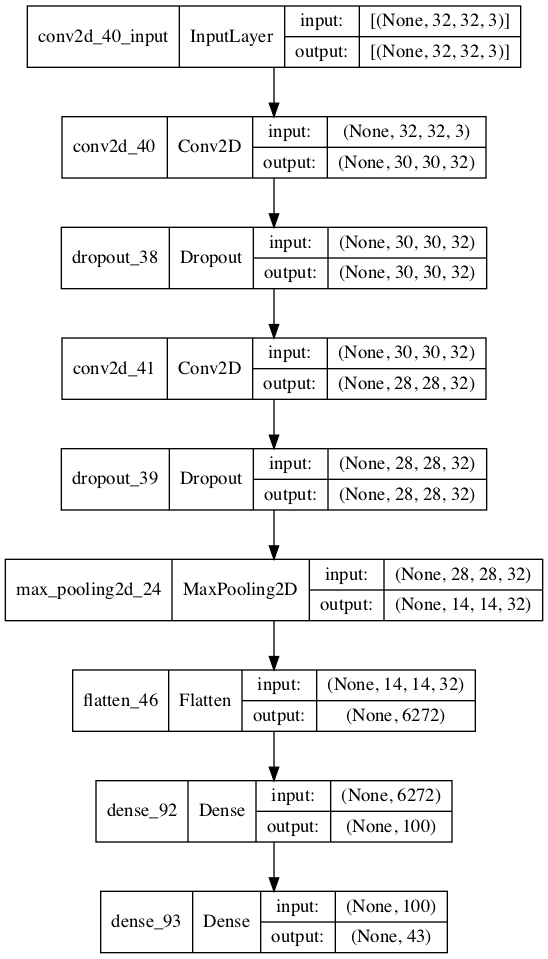

In [778]:
plot_model(model, to_file='modelfinal_plot.png', show_shapes=True, show_layer_names=True)